In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
import xgboost as xgb
import math
import datetime
import time


C:\Users\disha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [6]:
import pandas as pd
dataset_ex_df = pd.read_csv(r"C:\Users\disha\Downloads\archive (6)\RELIANCE.csv", header=0, parse_dates=[0], date_parser=parser)

In [7]:
dataset_ex_df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


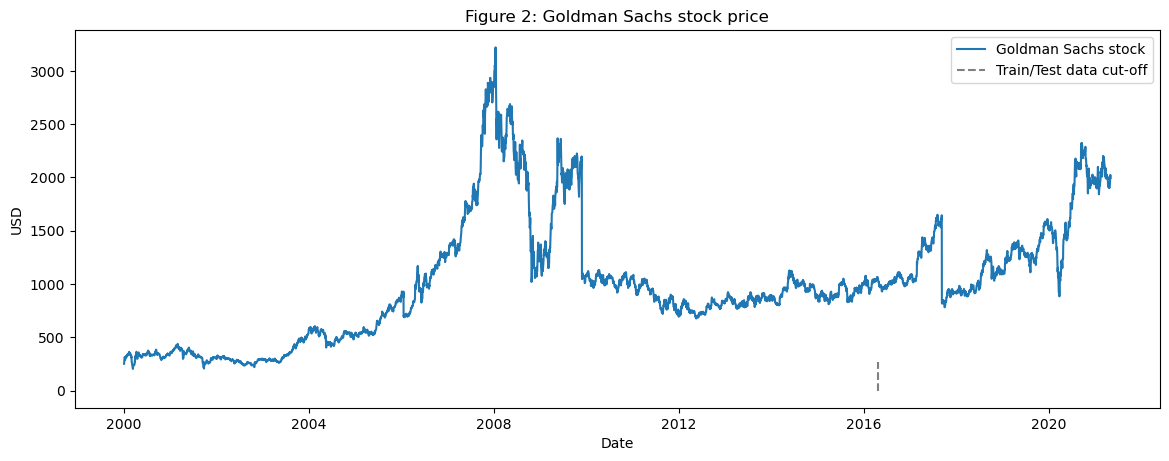

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [12]:
num_training_days = int(dataset_ex_df.shape[0]*.75)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 3979. Number of test days: 1327.


In [16]:
import pandas as pd

def get_technical_indicators(dataset):
    # Create moving average
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = dataset['12ema'] - dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd'] * 2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Close'] - 1

    return dataset


In [17]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [19]:
dataset_TI_df.drop(columns=['Symbol','Series','Trades','Deliverable Volume','%Deliverble'], inplace=True)

In [25]:
dataset_TI_df.dropna(inplace=True)

In [26]:
dataset_TI_df

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
20,2000-02-01,328.15,330.80,337.45,328.00,336.05,334.05,334.35,10707804,3.580137e+14,329.707143,309.769048,304.596708,322.026770,17.430062,17.758078,345.285204,274.252892,332.925860,333.05
21,2000-02-02,334.05,342.90,346.90,338.55,339.10,340.15,343.07,9950848,3.413884e+14,331.678571,313.980952,307.230286,324.814959,17.584674,15.971899,345.924750,282.037155,337.741953,339.15
22,2000-02-03,340.15,342.00,343.50,336.40,342.50,341.65,340.17,6771527,2.303447e+14,333.892857,317.304762,309.779894,327.404966,17.625071,14.863085,347.030931,287.578592,340.347318,340.65
23,2000-02-04,341.65,344.00,347.35,341.70,342.75,344.15,344.87,7106910,2.450931e+14,337.350000,320.240476,312.325828,329.981125,17.655297,14.678539,349.597554,290.883399,342.882439,343.15
24,2000-02-07,344.15,341.10,349.45,338.05,343.00,343.60,345.90,8193641,2.834154e+14,338.585714,322.585714,314.642433,332.076336,17.433903,15.371897,353.329509,291.841919,343.360813,342.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,1904.35,1920.00,1962.00,1911.50,1938.00,1937.85,1941.32,9620785,1.867699e+15,1918.264286,1972.052381,1977.915458,1939.489927,-38.425531,47.610894,2067.274169,1876.830593,1926.860390,1936.85
5302,2021-04-27,1937.85,1940.00,1997.20,1938.25,1990.00,1988.65,1978.64,9226547,1.825602e+15,1924.600000,1967.345238,1978.710609,1947.053015,-31.657594,44.029495,2055.404228,1879.286248,1968.053463,1987.65
5303,2021-04-28,1988.65,1997.85,2008.00,1980.15,1993.15,1997.30,1997.60,7902002,1.578508e+15,1933.914286,1964.964286,1980.087601,1954.783320,-25.304281,44.244918,2053.454122,1876.474449,1987.551154,1996.30
5304,2021-04-29,1997.30,2022.90,2044.50,2007.30,2020.00,2024.05,2024.21,8035915,1.626634e+15,1951.392857,1966.516667,1983.344075,1965.439733,-17.904342,45.790813,2058.098293,1874.935040,2011.883718,2023.05


In [31]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

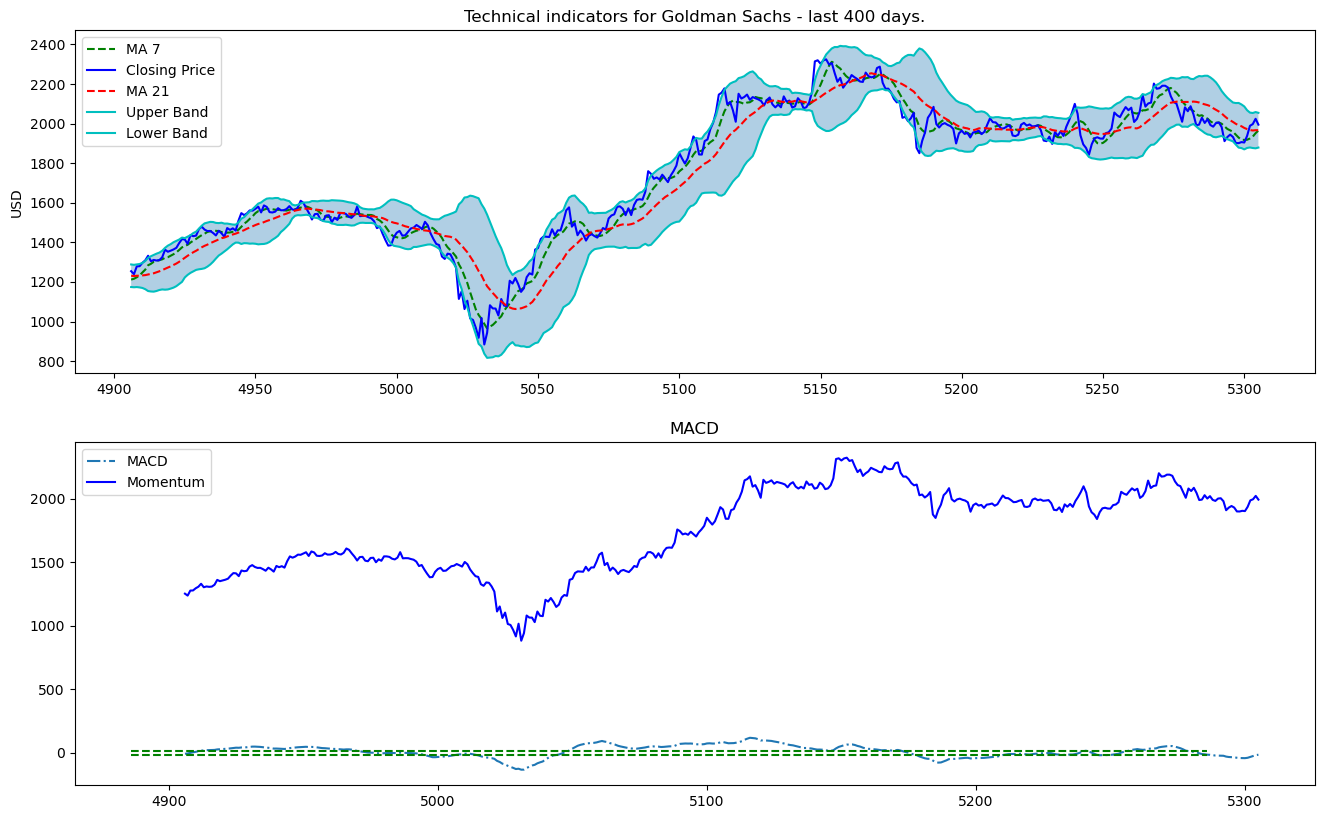

In [32]:
plot_technical_indicators(dataset_TI_df, 400)

In [33]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [35]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

(5286,)
(5286,)
(5286,)
(5286,)


C:\Users\disha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\disha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\disha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\disha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


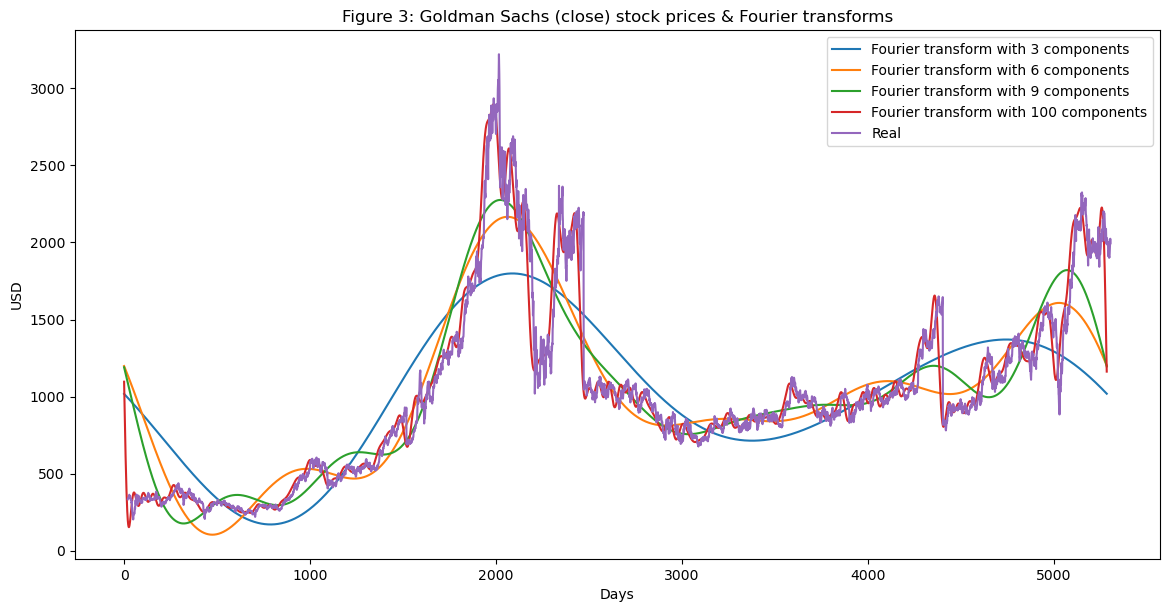

In [64]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

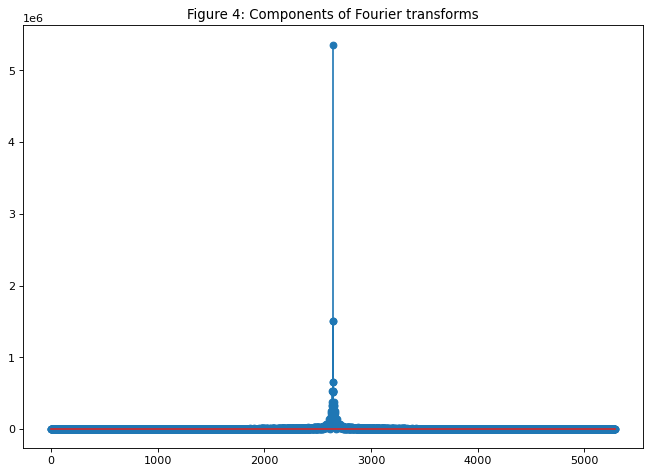

In [37]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [58]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

series = data_FT['Close']
# Fit ARIMA model
model = ARIMA(series, order=(5, 1, 0))  # (p, d, q) parameters
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

C:\Users\disha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\disha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\disha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5286
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -26034.651
Date:                Tue, 18 Jun 2024   AIC                          52081.302
Time:                        13:30:09   BIC                          52120.738
Sample:                             0   HQIC                         52095.085
                               - 5286                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0261      0.008      3.200      0.001       0.010       0.042
ar.L2      -7.573e-05      0.009     -0.008      0.993      -0.018       0.018
ar.L3         -0.0631      0.009     -7.183      0.0

In [41]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

ModuleNotFoundError: No module named 'pandas.tools'

In [59]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Users\disha\AppData\Local\Temp\ipykernel_9920\1968680099.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [45]:
size

3488

In [61]:
test

array([ 884.75,  869.75,  863.05, ..., 1997.3 , 2024.05, 1994.5 ])

In [62]:
predictions

[885.0771928211311,
 883.3905951970974,
 868.9755170506596,
 862.765499849755,
 874.0896884642456,
 866.6209962379402,
 867.7784510668185,
 842.8035863331479,
 844.6145242160901,
 838.5880027451359,
 825.1206061184276,
 833.0772986947281,
 821.6722567374178,
 821.7791496175846,
 818.2557539633284,
 815.8081295142596,
 815.1759167670393,
 822.4505009406105,
 804.9653394122499,
 817.8648952200468,
 808.2303006545122,
 821.7321782496305,
 813.1207090956483,
 811.7496142450046,
 813.0334615987026,
 804.8134220376849,
 812.1938604482228,
 812.9359225766908,
 810.2180639118628,
 810.7378575598926,
 799.4290412332603,
 803.5526702211696,
 814.2709876964487,
 806.7971159175595,
 822.5636910161979,
 871.1514586089257,
 884.4266823109537,
 870.1406777864432,
 867.8031070218283,
 878.2912300705576,
 886.3130333510098,
 896.6770807438243,
 902.5565535962199,
 904.6824087585209,
 883.9063984054239,
 887.3907162512094,
 907.3667110713382,
 878.598674644074,
 891.014609269948,
 902.6451178222852,
 91

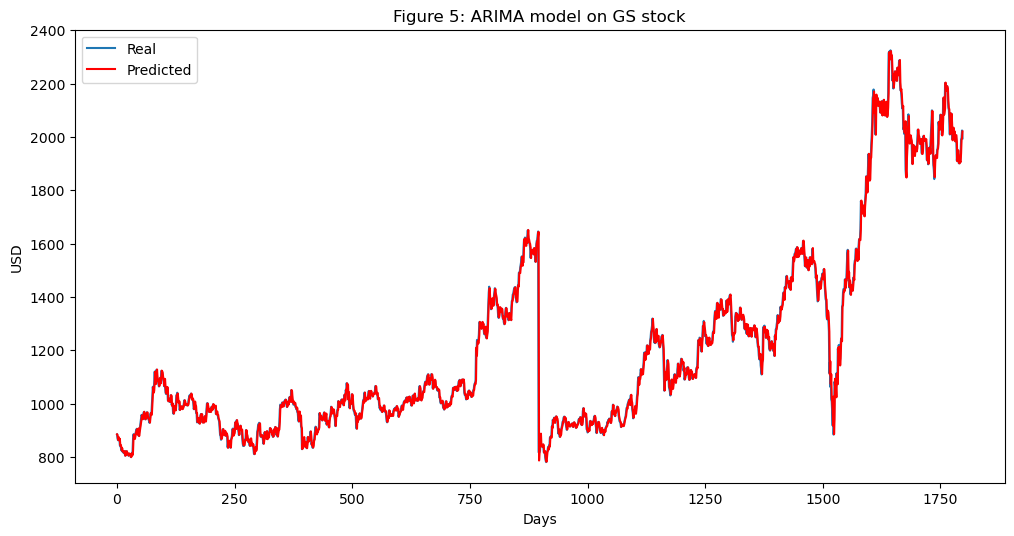

In [60]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()